A senior engineer in your team has requested that you predict the runoff hydrograph using different analytical approaches and contrast and compare the two in a technical report for internal audiences. The catchment details are shown below. The senior requested in particular the development of runoff hydrographs using both an analytical kinematic wave and a pond model approach (`Numerical Models`).

* Catchment area – 2.0 ha with dimensions of 100 m x 200 m
* Slope - 1.0%
* Roughness - 0.100
* Rainfall event - 63mm/h for 50 mins
* Losses - Initial losses of 2mm and continuing losses of 3mm/h.

At the outlet of the catchment, you can assume that flow is instantaneously transmitted from one edge of the catchment to the other in a channel.

Your report needs to present the two predicted hydrographs and a discussion of similarities and differences.  The senior engineer has requested a maximum of a 5 page report exclusive of calculations that can be included as appendices. Excel spreadsheets can be included as appendices. The report needs to adopt appropriate referencing and exploration of data as needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import math
import csv
import os

/home/holger/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# inputs
catch_area = 4          # ha
width = 200             # m
slope = 2.25            # %
roughness = 0.015       # s/m^1/3
intensity = 63          # mm/h
duration = 30           # min
ini_loss = 6            # mm
cont_loss = 3           # mm/h

step = 60               # s

for key, value in {
    'catch_area':catch_area,
    'width':width,
    'slope':slope,
    'roughness':roughness,
    'intensity':intensity,
    'duration':duration,
    'ini_loss':ini_loss,
    'cont_loss':cont_loss,
    'step':step
    }.items():
    print('{}: {}'.format(key, value), sep='\n')

catch_area: 4
width: 200
slope: 2.25
roughness: 0.015
intensity: 63
duration: 30
ini_loss: 6
cont_loss: 3
step: 60


In [3]:
arg_output_dir='./Outputs_CM_Assignment_3/'

arg_output_dir

'./Outputs_CM_Assignment_3/'

In [4]:
def create_output_dir(arg_output_dir):
    """create output directory if it does not exist

    arguments:
        arg_output_dir = [string] './Outputs_CM_Assignment_2/'
    """
    if not os.path.exists(arg_output_dir):
        os.makedirs(arg_output_dir)

In [5]:
create_output_dir(arg_output_dir)

In [6]:
catch_area = catch_area*10000
length = catch_area/width
slope = slope/100
intensity = intensity/(1000*3600)
duration = duration*60
ini_loss = ini_loss/1000
cont_loss = cont_loss/(1000*3600)

for key, value in {
    'catch_area':catch_area,
    'width':width,
    'length':length,
    'slope':slope,
    'roughness':roughness,
    'intensity':intensity,
    'duration':duration,
    'ini_loss':ini_loss,
    'cont_loss':cont_loss,
    'step':step
    }.items():
    print('{}: {}'.format(key, value), sep='\n')

catch_area: 40000
width: 200
length: 200.0
slope: 0.0225
roughness: 0.015
intensity: 1.75e-05
duration: 1800
ini_loss: 0.006
cont_loss: 8.333333333333333e-07
step: 60


In [7]:
ini_loss_dur = ini_loss/intensity
rainfall_excess = intensity - cont_loss
alpha = math.sqrt(slope)/roughness
beta = 5/3
time_conc_rel = (length/(alpha*(rainfall_excess**(beta - 1))))**(1/beta)
time_conc_abs = time_conc_rel + ini_loss_dur

for key, value in {
    'ini_loss_dur':ini_loss_dur,
    'rainfall_excess':rainfall_excess,
    'alpha':alpha,
    'beta':beta,
    'time_conc_rel':time_conc_rel,
    'time_conc_abs':time_conc_abs
    }.items():
    print('{}: {}'.format(key, value), sep='\n')

ini_loss_dur: 342.8571428571429
rainfall_excess: 1.6666666666666664e-05
alpha: 10.0
beta: 1.6666666666666667
time_conc_rel: 491.9018971698728
time_conc_abs: 834.7590400270158


In [8]:
var = {
    'catch_area':catch_area, 'width':width, 'length':length, 'slope':slope, 'roughness':roughness, 
    'intensity':intensity, 'duration':duration, 'ini_loss':ini_loss, 'cont_loss':cont_loss, 'ini_loss_dur':ini_loss_dur, 
    'rainfall_excess':rainfall_excess, 'alpha':alpha, 'beta':beta, 'time_conc_rel':time_conc_rel, 'time_conc_abs':time_conc_abs, 'step':step
    }

spaces = [' '*ind for ind in [max([len(ind) for ind in var.keys()]) - ind for ind in [len(ind) for ind in var.keys()]]]

for ind1, ind2 in zip(spaces, var.items()):
    print('{}{}:\t{}'.format(ind2[0], ind1, ind2[1]))

catch_area     :	40000
width          :	200
length         :	200.0
slope          :	0.0225
roughness      :	0.015
intensity      :	1.75e-05
duration       :	1800
ini_loss       :	0.006
cont_loss      :	8.333333333333333e-07
ini_loss_dur   :	342.8571428571429
rainfall_excess:	1.6666666666666664e-05
alpha          :	10.0
beta           :	1.6666666666666667
time_conc_rel  :	491.9018971698728
time_conc_abs  :	834.7590400270158
step           :	60


In [9]:
input_data = [{'key': key, 'value':val} for key, val in var.items()]
key_input = ['key', 'value']

with open (
    file='{}_data_Kinematic_and_Pond_model_A{}_W{}_L{}_S{}_I{}_D{}_IL{}_CL{}_ts{}.csv'.format(
        arg_output_dir, 
        int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ),
    mode='w',
    newline='') as file:
    writer = csv.DictWriter(file, fieldnames=key_input)
    writer.writeheader()
    writer.writerows(input_data)

In [10]:
def kinematic_wave_eq(
    step,
    ini_loss_dur,
    time_conc_abs,
    duration,
    rainfall_excess,
    alpha,
    beta,
    width,
    length
    ):

    # rl: rising limb
    rl_time_sec = np.concatenate((
        np.arange(start=0, stop=ini_loss_dur, step=step),
        np.array(object=[ini_loss_dur]),
        np.arange(start=ini_loss_dur - ini_loss_dur%step + step, stop=time_conc_abs, step=step),
        np.array(object=[time_conc_abs])
        ))
    rl_rel_time_sec = np.where(rl_time_sec - ini_loss_dur < 0, 0, rl_time_sec - ini_loss_dur)
    rl_depth = rl_rel_time_sec*rainfall_excess
    rl_unit_flow_rate = alpha*rl_depth**beta
    rl_flow_rate = rl_unit_flow_rate*width

    # el: equilibrium limb
    el_time_sec = np.arange(start=rl_time_sec[-1] - rl_time_sec[-1]%step + step, stop=duration, step=step)
    el_rel_time_sec = el_time_sec - ini_loss_dur
    el_depth = np.ones(shape=el_rel_time_sec.size)*rl_depth[-1]
    el_unit_flow_rate = np.ones(shape=el_rel_time_sec.size)*rl_unit_flow_rate[-1]
    el_flow_rate = np.ones(shape=el_rel_time_sec.size)*rl_flow_rate[-1]

    # fl: falling limb
    fl_time_sec = np.concatenate((
        np.array([duration]),
        np.arange(start=duration - duration%step + step, stop=duration*7, step=step),
        ))
    fl_rel_time_sec = fl_time_sec - ini_loss_dur
    fl_unit_flow_rate = []
    for t in fl_rel_time_sec:
        def solver_function(q, tr=duration - ini_loss_dur, t=t, i=rainfall_excess, l=length, b=beta, a=alpha):
            return q - i*l + (t - tr)*i*b*(a**(1/b))*(q**((b - 1)/b))
        q = optimize.root(fun=solver_function, x0=0, tol=1E-10)
        q = q.x[0]
        fl_unit_flow_rate.append(q)
    fl_unit_flow_rate = np.array(fl_unit_flow_rate)
    fl_depth = (fl_unit_flow_rate/alpha)**(1/beta)
    fl_flow_rate = fl_unit_flow_rate*width

    # wrapping up
    time_sec = np.concatenate((
        rl_time_sec,
        el_time_sec,
        fl_time_sec
        ))
    time_min = time_sec/60
    rel_time_sec = np.concatenate((
        rl_rel_time_sec,
        el_rel_time_sec,
        fl_rel_time_sec
        ))
    depth = np.concatenate((
        rl_depth,
        el_depth,
        fl_depth
        ))
    unit_flow_rate = np.concatenate((
        rl_unit_flow_rate,
        el_unit_flow_rate,
        fl_unit_flow_rate
        ))
    flow_rate = np.concatenate((
        rl_flow_rate,
        el_flow_rate,
        fl_flow_rate
        ))

    return pd.DataFrame(
        data=np.column_stack((
            time_min,
            time_sec,
            rel_time_sec,
            depth,
            unit_flow_rate,
            flow_rate
            )),
        columns=['t_min', 't_sec', 't_rel', 'y', 'q', 'Q'])

In [11]:
kin_results = kinematic_wave_eq(
    step,
    ini_loss_dur,
    time_conc_abs,
    duration,
    rainfall_excess,
    alpha,
    beta,
    width,
    length
    )
kin_results.to_csv(
    path_or_buf='{}Q_Kinematic_model_A{}_W{}_L{}_S{}_I{}_D{}_IL{}_CL{}_ts{}.csv'.format(
        arg_output_dir, 
        int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ), index=False)

kin_results

,t_min,t_sec,t_rel,y,q,Q
0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000
1,1.0,60.0,0.000000,0.000000,0.000000e+00,0.000000
2,2.0,120.0,0.000000,0.000000,0.000000e+00,0.000000
3,3.0,180.0,0.000000,0.000000,0.000000e+00,0.000000
4,4.0,240.0,0.000000,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...
207,205.0,12300.0,11957.142857,0.000039,4.414038e-07,0.000088
208,206.0,12360.0,12017.142857,0.000038,4.351626e-07,0.000087
209,207.0,12420.0,12077.142857,0.000038,4.290442e-07,0.000086
210,208.0,12480.0,12137.142857,0.000038,4.230456e-07,0.000085


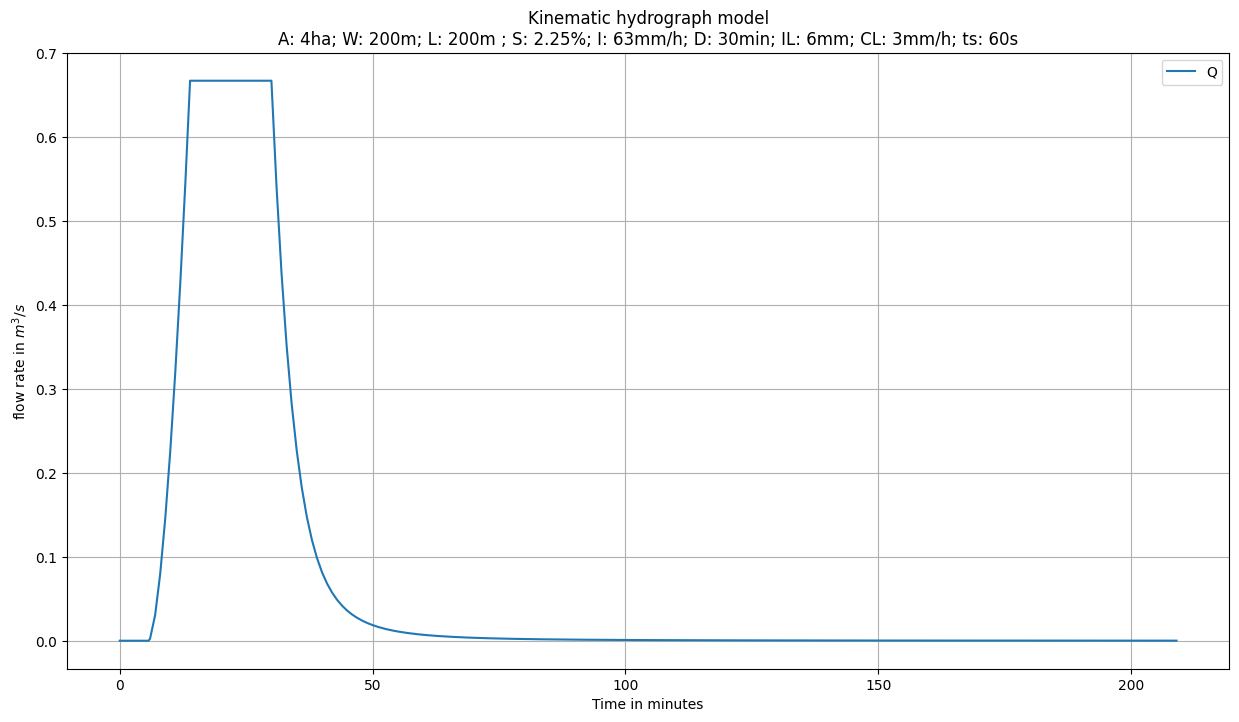

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
ax = kin_results.plot(
    x='t_min',
    y='Q',
    kind='line',
    ax=ax,
    title='Kinematic hydrograph model\nA: {}ha; W: {}m; L: {}m ; S: {}%; I: {}mm/h; D: {}min; IL: {}mm; CL: {}mm/h; ts: {}s'.format(
        int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ),
    grid=True,
    xlabel='Time in minutes',
    ylabel='flow rate in $m^{3}/s$'
    )
fig.savefig(
    fname='{}Q_Kinematic_model_A{}_W{}_L{}_S{}_I{}_D{}_IL{}_CL{}_ts{}.png'.format(
        arg_output_dir, 
        int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ))

In [13]:
def pond_model_eq(
    step,
    ini_loss_dur,
    time_conc_abs,
    duration,
    rainfall_excess,
    alpha,
    beta,
    width,
    length
    ):

    time_sec = np.concatenate((
        np.arange(start=0, stop=ini_loss_dur, step=step),
        np.array([ini_loss_dur]),
        np.arange(start=ini_loss_dur - ini_loss_dur%step + step, stop=time_conc_abs, step=step),
        np.array([time_conc_abs]),
        np.arange(start=time_conc_abs - time_conc_abs%step + step, stop=duration, step=step),
        np.array([duration]),
        np.arange(start=duration - duration%step + step, stop=duration*7, step=step)
    ))
    time_min = time_sec/60

    delta_time = np.concatenate((
        np.array([0]),
        np.diff(a=time_sec)
        ))

    i_prom = np.where((time_sec <= ini_loss_dur) | (time_sec > duration), 0, rainfall_excess*width*length*delta_time)

    depth = []
    y0 = 0
    for dt, ip in zip(delta_time, i_prom):
        def solver_function(y1, y0=y0, w=width, l=length, a=alpha, b=beta, dt=dt, ip=ip):
            return ip - w*a*(y1**b + y0**b)*dt/2 - w*l*(y1 - y0)
        y1 = optimize.root(fun=solver_function, x0=0, tol=1E-10)
        y1 = y1.x[0]
        depth.append(y1)
        y0 = y1
    depth = np.array(depth)

    o_prom = []
    y0 = 0
    for y1, dt in zip(depth, delta_time):
        op = width*alpha*(y0**beta + y1**beta)*dt/2
        o_prom.append(op)
        y0 = y1
    o_prom = np.array(o_prom)

    flow_rate = width*alpha*(depth**beta)

    return pd.DataFrame(
        data=np.column_stack((time_min, time_sec, delta_time, i_prom, o_prom, depth, flow_rate)),
        columns=['t_min', 't_sec', 'dt', 'i_prom', 'o_prom', 'y', 'Q'])

In [14]:
pond_results = pond_model_eq(
    step,
    ini_loss_dur,
    time_conc_abs,
    duration,
    rainfall_excess,
    alpha,
    beta,
    width,
    length
    )
pond_results.to_csv(
    path_or_buf='{}Q_Pond_model_A{}_W{}_L{}_S{}_I{}_D{}_IL{}_CL{}_ts{}.csv'.format(
        arg_output_dir, 
        int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ), index=False)

pond_results

,t_min,t_sec,dt,i_prom,o_prom,y,Q
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,1.0,60.0,60.0,0.0,0.000000,0.000000,0.000000
2,2.0,120.0,60.0,0.0,0.000000,0.000000,0.000000
3,3.0,180.0,60.0,0.0,0.000000,0.000000,0.000000
4,4.0,240.0,60.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
207,205.0,12300.0,60.0,0.0,0.044395,0.000138,0.000735
208,206.0,12360.0,60.0,0.0,0.043807,0.000137,0.000725
209,207.0,12420.0,60.0,0.0,0.043230,0.000136,0.000716
210,208.0,12480.0,60.0,0.0,0.042663,0.000135,0.000706


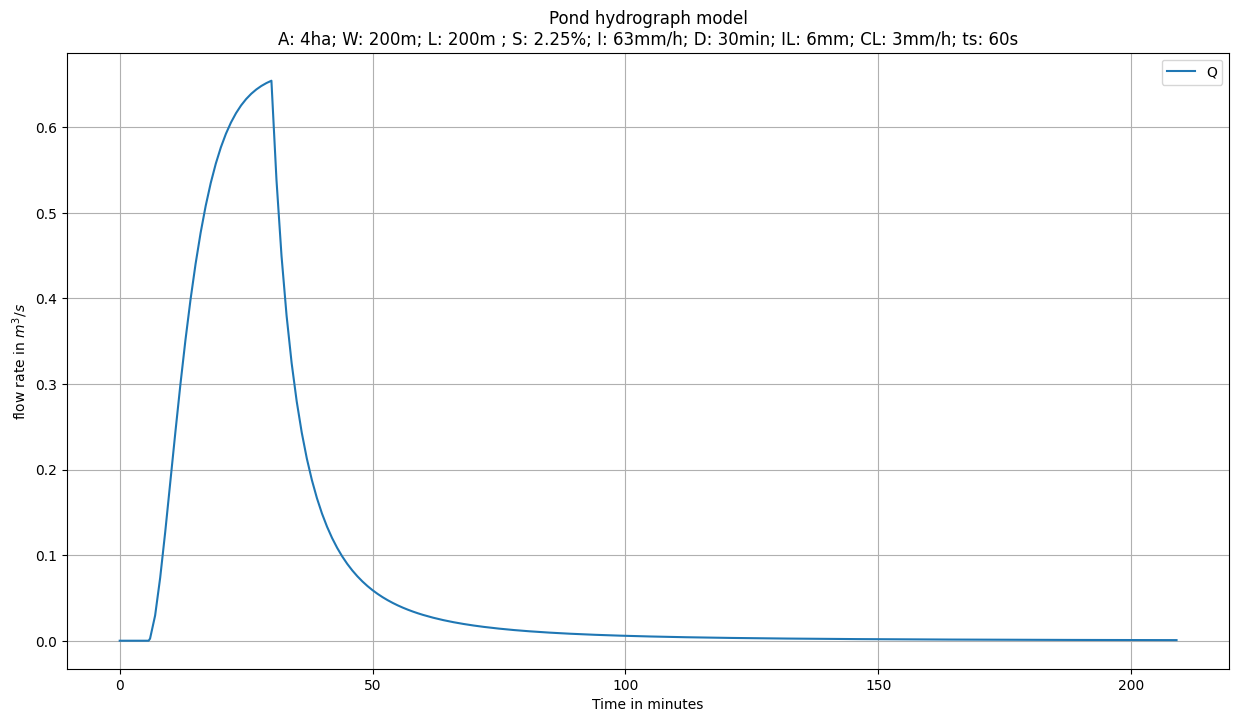

In [15]:
fig, ax = plt.subplots(figsize=(15,8))
ax = pond_results.plot(
    x='t_min',
    y='Q',
    kind='line',
    ax=ax,
    title='Pond hydrograph model\nA: {}ha; W: {}m; L: {}m ; S: {}%; I: {}mm/h; D: {}min; IL: {}mm; CL: {}mm/h; ts: {}s'.format(
        int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ),
    grid=True,
    xlabel='Time in minutes',
    ylabel='flow rate in $m^{3}/s$'
    )
fig.savefig(
    fname='{}Q_Pond_model_A{}_W{}_L{}_S{}_I{}_D{}_IL{}_CL{}_ts{}.png'.format(
        arg_output_dir, 
        int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ))

In [16]:
kin_pond_results = pd.concat(objs=[
    kin_results.t_sec,
    kin_results.t_min,
    kin_results.Q,
    # pond_results.t_sec,
    # pond_results.t_min,
    pond_results.Q
    ], axis=1)
kin_pond_results.columns = [
    't_sec', 't_min',
    # 't_sec_kinematic', 't_min_kinematic', 
    'Q_Kinematic_model', 
    # 't_sec_pond', 't_min_pond', 
    'Q_Pond_model']
kin_pond_results.to_csv(
    path_or_buf='{}Kinematic_and_Pond_model_A{}_W{}_L{}_S{}_I{}_D{}_IL{}_CL{}_ts{}.csv'.format(
        arg_output_dir, 
        int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ), index=False)

kin_pond_results

,t_sec,t_min,Q_Kinematic_model,Q_Pond_model
0,0.0,0.0,0.000000,0.000000
1,60.0,1.0,0.000000,0.000000
2,120.0,2.0,0.000000,0.000000
3,180.0,3.0,0.000000,0.000000
4,240.0,4.0,0.000000,0.000000
...,...,...,...,...
207,12300.0,205.0,0.000088,0.000735
208,12360.0,206.0,0.000087,0.000725
209,12420.0,207.0,0.000086,0.000716
210,12480.0,208.0,0.000085,0.000706


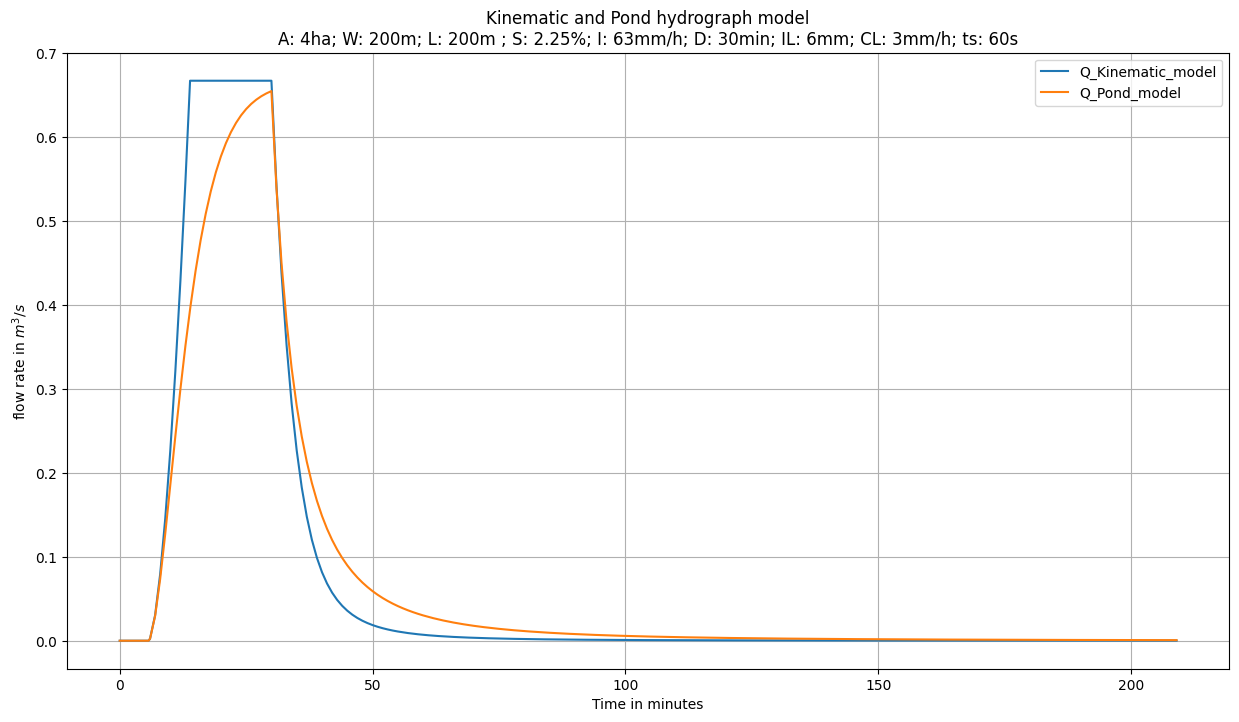

In [17]:
fig, ax = plt.subplots(figsize=(15,8))

ax = kin_pond_results.plot(
    # x='t_min_kinematic',
    x='t_min',
    y='Q_Kinematic_model',
    kind='line',
    ax=ax
    )

ax = kin_pond_results.plot(
    # x='t_min_pond',
    x='t_min',
    y='Q_Pond_model',
    kind='line',
    ax=ax
    )

ax.set_title('Kinematic and Pond hydrograph model\nA: {}ha; W: {}m; L: {}m ; S: {}%; I: {}mm/h; D: {}min; IL: {}mm; CL: {}mm/h; ts: {}s'.format(
    int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ))
ax.grid(visible=True)
ax.set_xlabel(xlabel='Time in minutes')
ax.set_ylabel(ylabel='flow rate in $m^{3}/s$')

fig.savefig(
    fname='{}Kinematic_and_Pond_model_A{}_W{}_L{}_S{}_I{}_D{}_IL{}_CL{}_ts{}.png'.format(
        arg_output_dir, 
        int(round(catch_area/10000, 0)), 
        int(width), 
        int(length), 
        slope*100,
        int(round(intensity*1000*3600, 0)),
        int(duration/60),
        int(round(ini_loss*1000, 0)),
        int(round(cont_loss*1000*3600, 0)),
        step
        ))

In [18]:
# kin_results.t_min.apply(lambda arg: pd.Timedelta(minutes=arg))